In [1]:
import numpy as np
import matplotlib.pyplot as plt
import corner

from getdist import plots
from getdist import MCSamples

import paperfig as pf
from kinematics_likelihood import KinematicLikelihood
from data_util import *

pf.set_fontscale(2.)

In [2]:
walker_ratio = 6

labels_pl = ['theta_E', 'gamma', 'q', 'pa', 'D_dt', 'inclination', 'lamda', 'ani_param_1', 
          'ani_param_2', 'ani_param_3'] #[:samples_mcmc.shape[1]]
latex_labels_pl = ['{\\theta}_{\\rm E} \ (^{\prime\prime})', 
                '{\\gamma}',
                'q', '{\\rm PA} {\ (^{\circ})}',
                'D_{\\Delta t}\ ({\\rm Mpc})',
                'i {\ (^{\circ})}',
                '{\\lambda_{\\rm MST}}',
                'a_{\\rm ani, 1}', 'a_{\\rm ani,2}', 'a_{\\rm ani,3}' 
               ]

labels_composite = ['kappa_s', 'r_scale', 'M/L', 'q', 'pa', 'D_dt', 'inclination', 'lamda', 'ani_param_1', 
          'ani_param_2', 'ani_param_3'] #[:samples_mcmc.shape[1]]
latex_labels_composite = ['{\\kappa}_{\\rm s}', 
                'r_{\\rm scale}',
                'M/L\ (M_{\\odot}/L_{\\odot}})',
                'q', '{\\rm PA} {\ (^{\circ})}',
                'D_{\\Delta t}\ ({\\rm Mpc})',
                'i {\ (^{\circ})}',
                '{\\lambda_{\\rm MST}}',
                'a_{\\rm ani, 1}', 'a_{\\rm ani,2}', 'a_{\\rm ani,3}' 
               ]

def get_init_pos(software, aperture_type, anisotropy_model, is_spherical, lens_model_type='powerlaw'):
    """
    """
    likelihood_class = KinematicLikelihood(lens_model_type=lens_model_type,
                                           software=software,
                                           anisotropy_model=anisotropy_model,
                                           aperture=aperture_type,
                                           snr_per_bin=15,
                                           is_spherical=is_spherical,
                                           mpi=False
                                           )

    walker_ratio = 6
    num_steps = 500
    num_param = 8 
    num_walker = num_param * walker_ratio * 1000

    init_lens_params = np.random.multivariate_normal(
        likelihood_class.lens_model_posterior_mean,
        cov=likelihood_class.lens_model_posterior_covariance,
        size=num_walker)

    init_pos = np.concatenate((
        init_lens_params,
        # lambda, ani_param, inclination (deg)
        np.random.normal(loc=[90, 1, 1], scale=[5, 0.05, 0.1],
                         size=(num_walker, 3))
    ), axis=1)
    
    return init_pos


def get_chain(software, aperture_type, anisotropy_model, is_spherical, lens_model_type='powerlaw'):
    """
    Get dynamics chain in right shape.
    """
    samples_mcmc = np.loadtxt(
        '../dynamics_chains_old/kcwi_dynamics_chain_{}_{}_{}_{}_{}.txt'.format(
            software, aperture_type, anisotropy_model, str(is_spherical), lens_model_type
        )
    )
    
    n_params = samples_mcmc.shape[1]

    n_walkers = walker_ratio * n_params
    n_step = int(samples_mcmc.shape[0] / n_walkers)

    # print('N_step: {}, N_walkers: {}, N_params: {}'.format(n_step, n_walkers, n_params))

    chain = np.empty((n_walkers, n_step, n_params))

    for i in np.arange(n_params):
        samples = samples_mcmc[:, i].T
        chain[:,:,i] = samples.reshape((n_step, n_walkers)).T
        
    return chain


def plot_mcmc_trace(software, aperture_type, anisotropy_model, is_spherical, lens_model_type='powerlaw'):
    """
    """
    chain = get_chain(software, aperture_type, anisotropy_model, is_spherical, lens_model_type)
    
    n_params = chain.shape[2]
    n_walkers = chain.shape[0]
    n_step = chain.shape[1]
    
    mean_pos = np.zeros((n_params, n_step))
    median_pos = np.zeros((n_params, n_step))
    std_pos = np.zeros((n_params, n_step))
    q16_pos = np.zeros((n_params, n_step))
    q84_pos = np.zeros((n_params, n_step))
    
    if lens_model_type == 'powerlaw':
        labels = labels_pl
        latex_labels = latex_labels_pl
    else:
        labels = labels_composite
        latex_labels = latex_labels_composite
        
    for i in np.arange(n_params):
        for j in np.arange(n_step):
            mean_pos[i][j] = np.mean(chain[:, j, i])
            median_pos[i][j] = np.median(chain[:, j, i])
            std_pos[i][j] = np.std(chain[:, j, i])
            q16_pos[i][j] = np.percentile(chain[:, j, i], 16.)
            q84_pos[i][j] = np.percentile(chain[:, j, i], 84.)

    fig, ax = plt.subplots(n_params, sharex=True, figsize=(8, 6))

    burnin = -50
    last = n_step

    medians = []

    param_values = [median_pos[0][last-1], (q84_pos[0][last-1]-q16_pos[0][last-1])/2,
                    median_pos[1][last-1], (q84_pos[1][last-1]-q16_pos[1][last-1])/2]

    for i in range(n_params):
        print(labels[i], '{:.4f} ± {:.4f}'.format(median_pos[i][last-1], (q84_pos[i][last-1]-q16_pos[i][last-1])/2))

        ax[i].plot(median_pos[i][:last], c='g')
        ax[i].axhline(np.median(median_pos[i][burnin:last]), c='r', lw=1)
        ax[i].fill_between(np.arange(last), q84_pos[i][:last], q16_pos[i][:last], alpha=0.4)
        ax[i].set_ylabel(labels[i], fontsize=10)
        ax[i].set_xlim(0, last)

        medians.append(np.median(median_pos[i][burnin:last]))


    fig.set_size_inches((12., 2*n_params))
    plt.show()
    
    
def plot_corner(software, aperture_type, anisotropy_model, is_spherical, lens_model_type='powerlaw',
                fig=None, color='k', burnin=-100, plot_init=False
               ):
    """
    """
    if lens_model_type == 'powerlaw':
        labels = labels_pl
        latex_labels = latex_labels_pl
    else:
        labels = labels_composite
        latex_labels = latex_labels_composite
        
    chain = get_chain(software, aperture_type, anisotropy_model, is_spherical, lens_model_type,
                      burnin=burnin
                     )
    
    
    fig = corner.corner(chain[:, burnin:, :].reshape((-1, chain.shape[-1])),
                        color=color, labels=labels, scale_hist=False, fig=fig,
                       );
    
    if plot_init:
        init_pos = get_init_pos(software, aperture_type, anisotropy_model, is_spherical, lens_model_type)
        
        corner.corner(init_pos, color='k', labels=labels, 
                      scale_hist=False, fig=fig)
    
    return fig


def get_getdist_samples(software, aperture_type, anisotropy_model, is_spherical, lens_model_type='powerlaw',
                        burnin=-100
                       ):
    """
    """
    if lens_model_type == 'powerlaw':
        labels = labels_pl
        latex_labels = latex_labels_pl
    else:
        labels = labels_composite
        latex_labels = latex_labels_composite
        
    chain = get_chain(software, aperture_type, anisotropy_model, is_spherical, lens_model_type)
    
    chain = chain[:, burnin:, :].reshape((-1, chain.shape[-1]))
    
    mc_samples= MCSamples(samples=chain, 
                          names=labels[:chain.shape[-1]], 
                          labels=latex_labels[:chain.shape[-1]]
                         )
    
    return mc_samples


def plot_dist(softwares, aperture_types, anisotropy_models, is_sphericals, lens_model_types,
              burnin=-100, legend_labels=[], save_fig=None
             ):
    """
    """
    if 'powerlaw' in lens_model_types:
        labels = labels_pl
        latex_labels = latex_labels_pl
    else:
        labels = labels_composite
        latex_labels = latex_labels_composite
        
    mc_samples_list = []
    
    for s, a, ani, sph, model in zip(softwares, aperture_types, 
                                     anisotropy_models, is_sphericals, lens_model_types):
        mc_samples_list.append(get_getdist_samples(s, a, ani, sph, model, burnin=burnin))
        
    g = plots.getSubplotPlotter(subplot_size=2.2)
    g.settings.lw_contour = 1.
    g.settings.alpha_factor_contour_lines = 2.
    g.settings.solid_contour_palefactor = 0.5
    g.settings.axes_fontsize = 16
    g.settings.lab_fontsize = 16

    g.settings.legend_fontsize = 18
    # g.settings.smooth_scale_2D = 4
    # g.settings.smooth_scale_1D = 4

    colors = [pf.cb2_blue, pf.cb2_orange, pf.cb2_emerald, pf.cb_grey]

    g.triangle_plot(mc_samples_list,
                    legend_labels=legend_labels,
                    filled=True, shaded=False,
                    alpha_filled_add=.5, 
                    contour_lws=[2 for l in legend_labels], 
                    contour_ls=['-' for l in legend_labels],
                    #filled=False,
                    #contour_colors=[sns.xkcd_rgb['emerald'], sns.xkcd_rgb['bright orange']], 
                    contour_args={'alpha': .5},
                    #line_args={'lw': 7., "zorder": 30},
                    #line_args={'lw': 1., 'alpha': 1.}
                    contour_colors=colors,
#                     param_limits={'dphi_AB': (-0.45, 0.15), 
#                                   'dphi_AC': (-0.45, 0.15), 
#                                   'dphi_AD': (-0.45, 0.15), 
#                                   'lambda_int': (0.3, 3), 'a_ani': (0.5, 5.)},
                   )

    #g.fig.tight_layout()
    if save_fig is not None:
        g.fig.savefig(save_fig, 
                      bbox_inches='tight')


def get_most_likely_value(software, aperture_type, anisotropy_model, is_spherical, 
                          lens_model_type='powerlaw', burnin=-100):
    """
    """
    chain = get_chain(software, aperture_type, anisotropy_model, is_spherical, lens_model_type)
    
    return np.mean(chain[:, burnin:, :].reshape((-1, chain.shape[-1])), 
                   axis=0)

def plot_residual(software, aperture_type, anisotropy_model, is_spherical, 
                  lens_model_type='powerlaw', burnin=-100, verbose=True):
    """
    """
    likelihood_class = KinematicLikelihood(lens_model_type=lens_model_type,
                                           software=software,
                                           anisotropy_model=anisotropy_model,
                                           aperture=aperture_type,
                                           snr_per_bin=15,
                                           is_spherical=is_spherical,
                                           mpi=False
                                           )

    params = get_most_likely_value(software, aperture_type, anisotropy_model, is_spherical, 
                                   lens_model_type, burnin)
    
    v_rms = likelihood_class.get_v_rms(params)

    model_v_rms = get_kinematics_maps(v_rms, likelihood_class.voronoi_bin_mapping)
    data_v_rms = get_kinematics_maps(likelihood_class.velocity_dispersion_mean,
                                     likelihood_class.voronoi_bin_mapping
                                     )
    noise_v_rms = get_kinematics_maps(
        np.sqrt(np.diag(likelihood_class.velocity_dispersion_covariance)),
        likelihood_class.voronoi_bin_mapping
    )
    
    if verbose:
        print('reduced chi^2: {:.2f}'.format(-2 * likelihood_class.get_log_likelihood(params) 
                                             / len(likelihood_class.velocity_dispersion_mean)))

    im = plt.matshow((data_v_rms - model_v_rms) / noise_v_rms,
                vmax=3, vmin=-3, cmap='RdBu_r', origin='lower'
                )
    plt.colorbar(im)
    plt.title('{}, {}, {}'.format(software, anisotropy_model, is_spherical))
    plt.show()

    
def get_bic(software, aperture_type, anisotropy_model, is_spherical, 
            lens_model_type='powerlaw', burnin=-100):
    """
    """
    likelihood_class = KinematicLikelihood(lens_model_type=lens_model_type,
                                           software=software,
                                           anisotropy_model=anisotropy_model,
                                           aperture=aperture_type,
                                           snr_per_bin=15,
                                           is_spherical=is_spherical,
                                           mpi=False
                                           )
    
    params = get_most_likely_value(software, aperture_type, anisotropy_model, is_spherical, 
                                   lens_model_type, burnin)
    
    log_likelihood = likelihood_class.get_log_likelihood(params)
    num_params = len(params)
    num_data = len(likelihood_class.velocity_dispersion_mean)
    
    bic = num_params * np.log(num_data) - 2 * log_likelihood
    
    return bic

theta_E 1.6333 ± 0.0102
gamma 1.9642 ± 0.0382
q 0.7620 ± 0.0056
pa 115.7318 ± 0.4902
D_dt 1874.0508 ± 78.8737
inclination 89.6666 ± 21.9292
lamda 0.8727 ± 0.0488
ani_param_1 1.2665 ± 0.0718


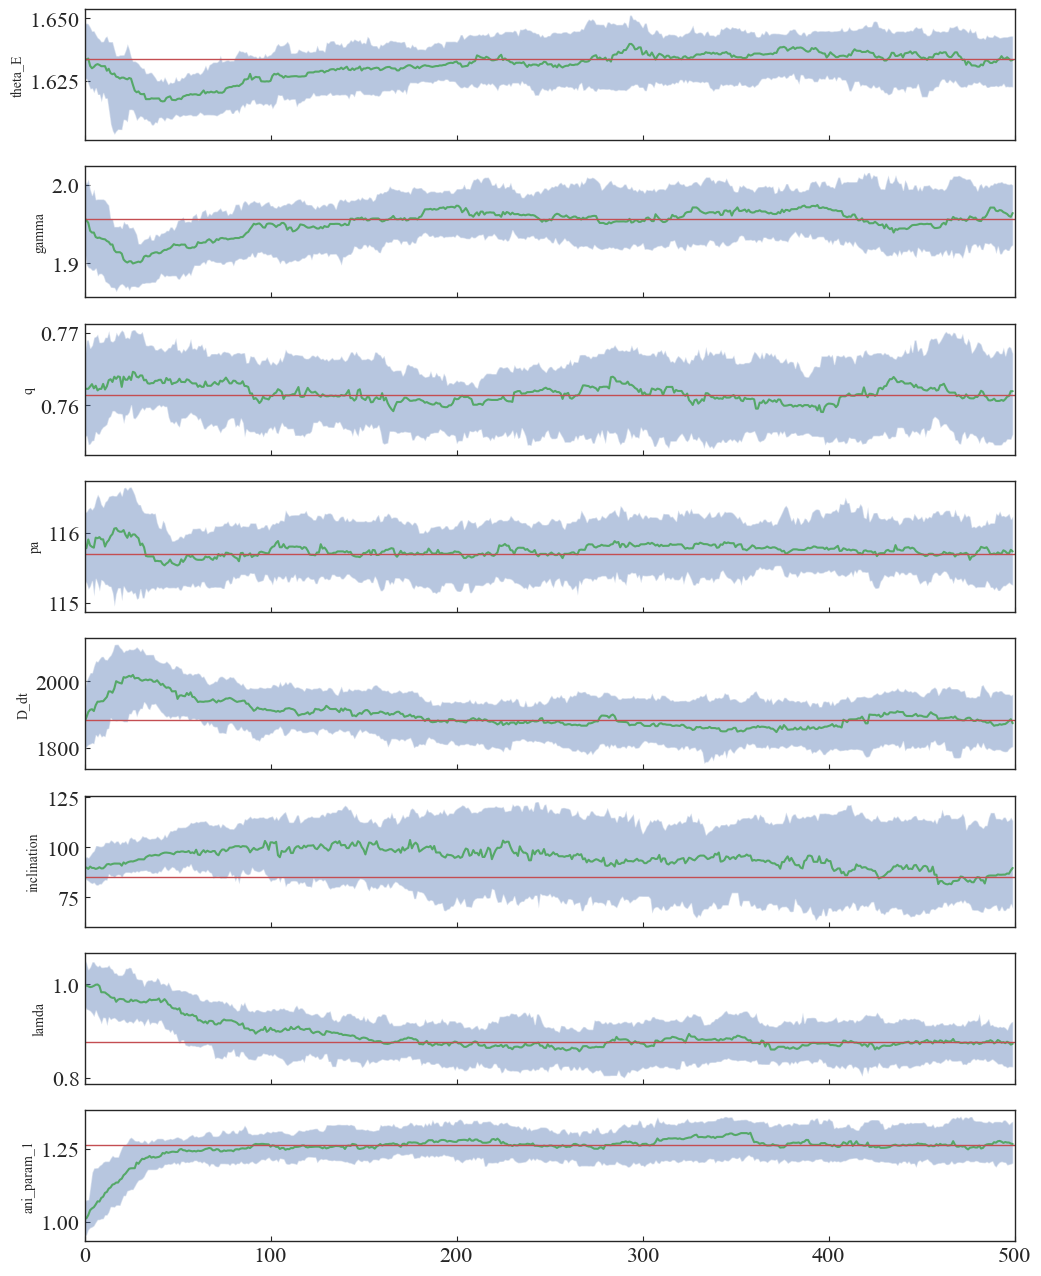

In [13]:
plot_mcmc_trace('jampy', 'ifu', 'constant', False, 'powerlaw')

In [4]:
get_most_likely_value('jampy', 'ifu', 'Osipkov-Merritt', True, 'powerlaw')

array([1.63174478e+00, 1.87597394e+00, 7.72965328e-01, 1.16212756e+02,
       2.03959080e+03, 9.51929713e+01, 5.77998406e-01, 2.23470246e+00])

Removed no burn in
Removed no burn in


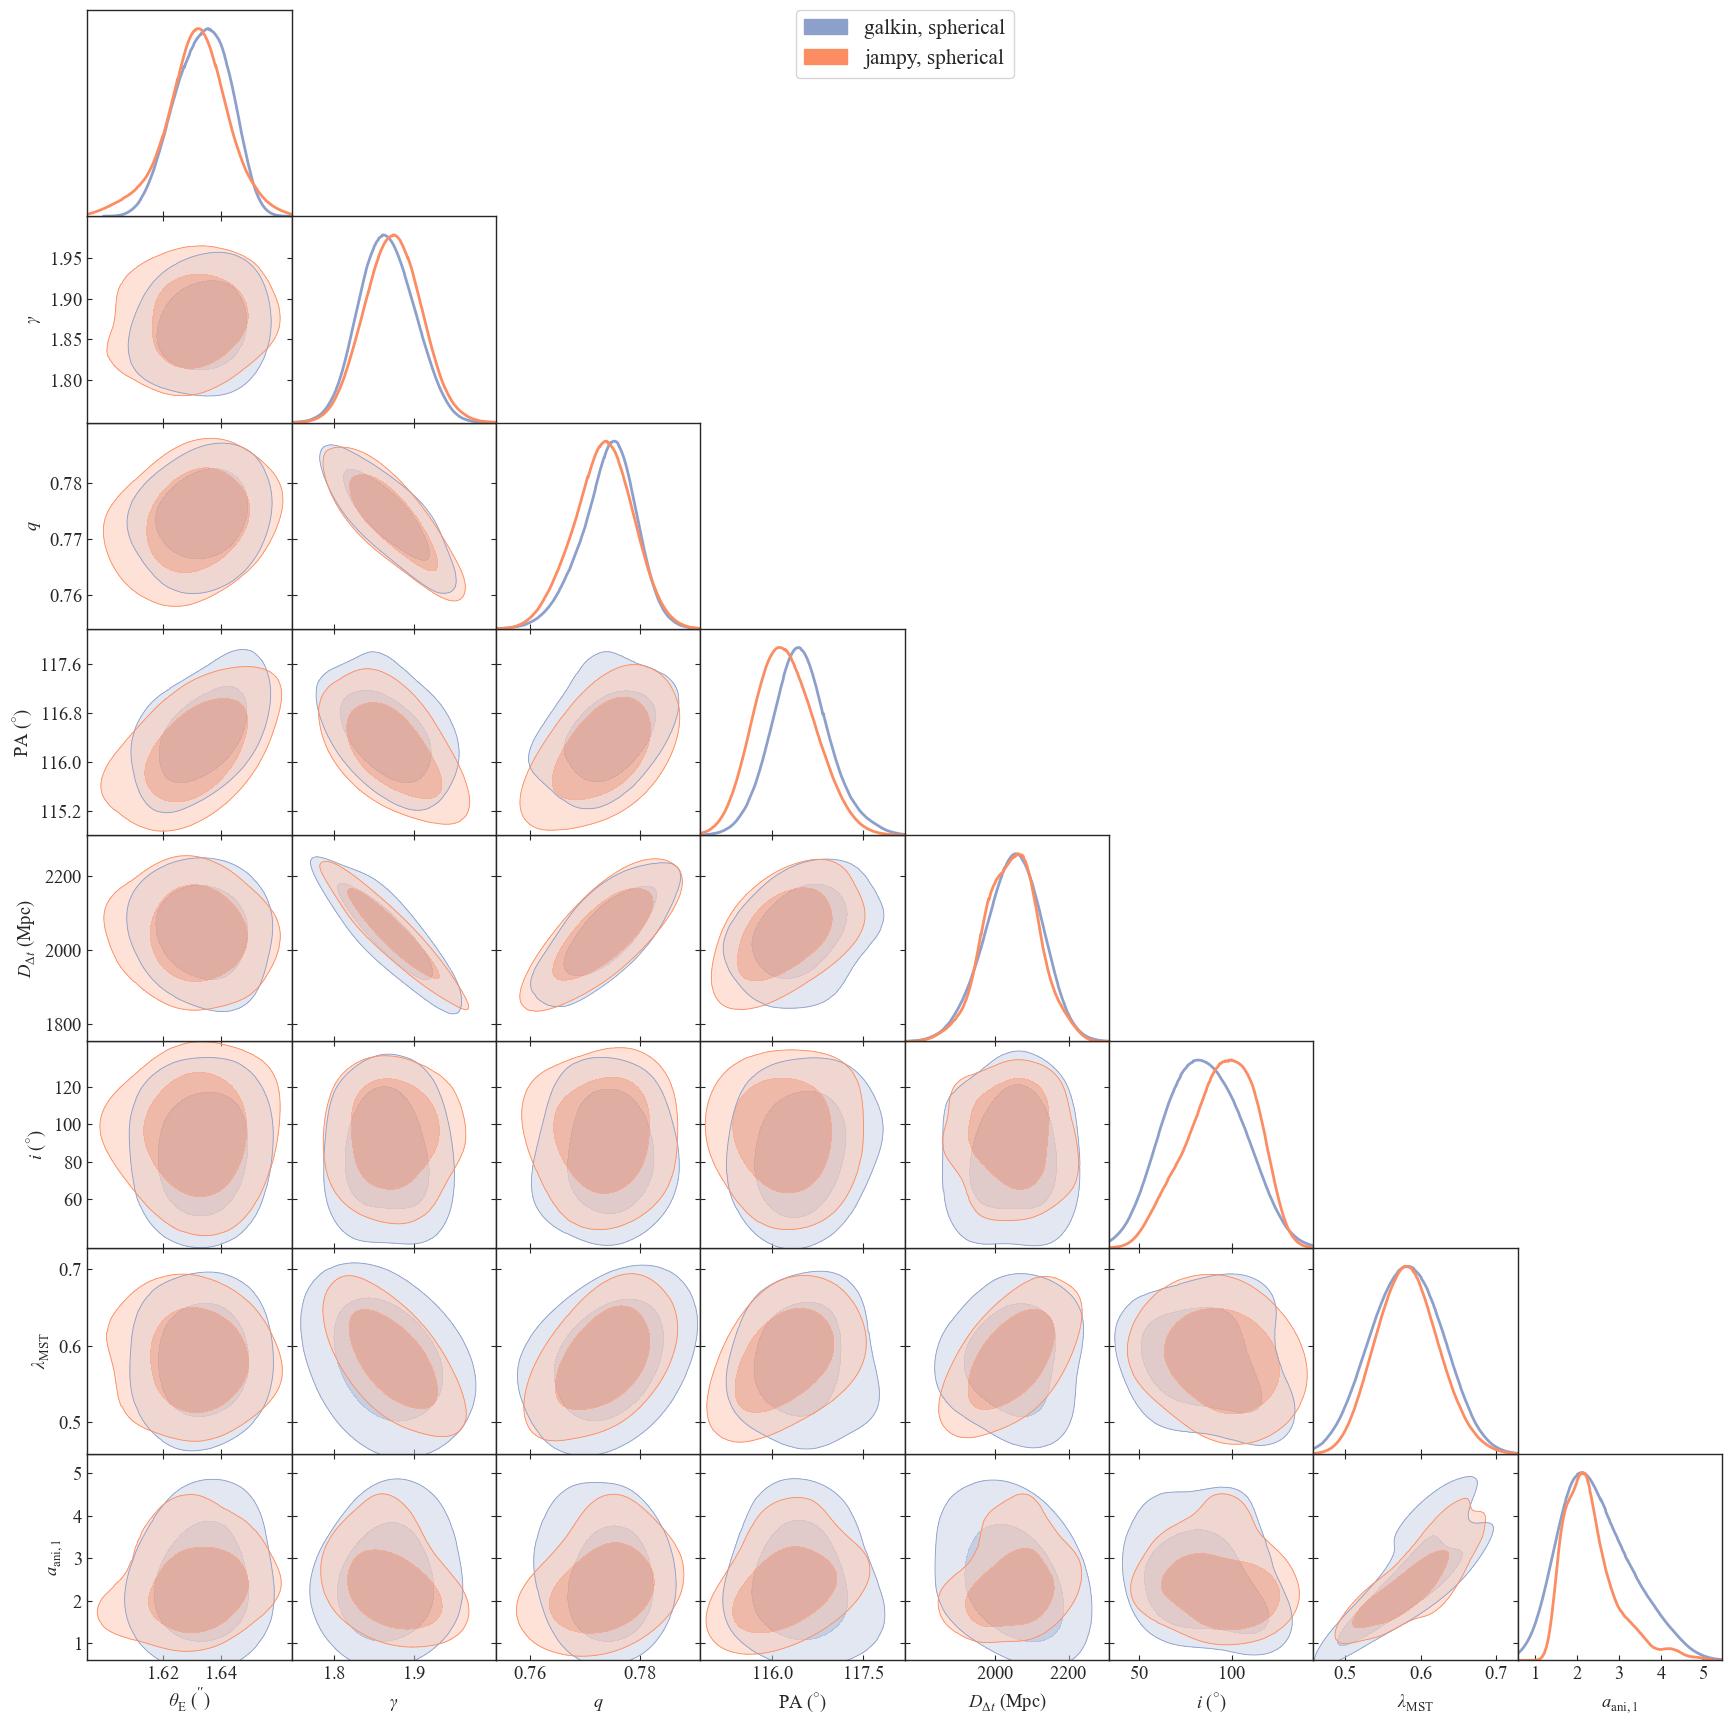

In [5]:
plot_dist(['galkin', 'jampy'], 
          ['ifu', 'ifu'], 
          ['Osipkov-Merritt', 'Osipkov-Merritt'], 
          [True, True], 
          ['powerlaw', 'powerlaw'], 
          burnin=-50, legend_labels=['galkin, spherical', 'jampy, spherical'])

Removed no burn in
Removed no burn in
Removed no burn in


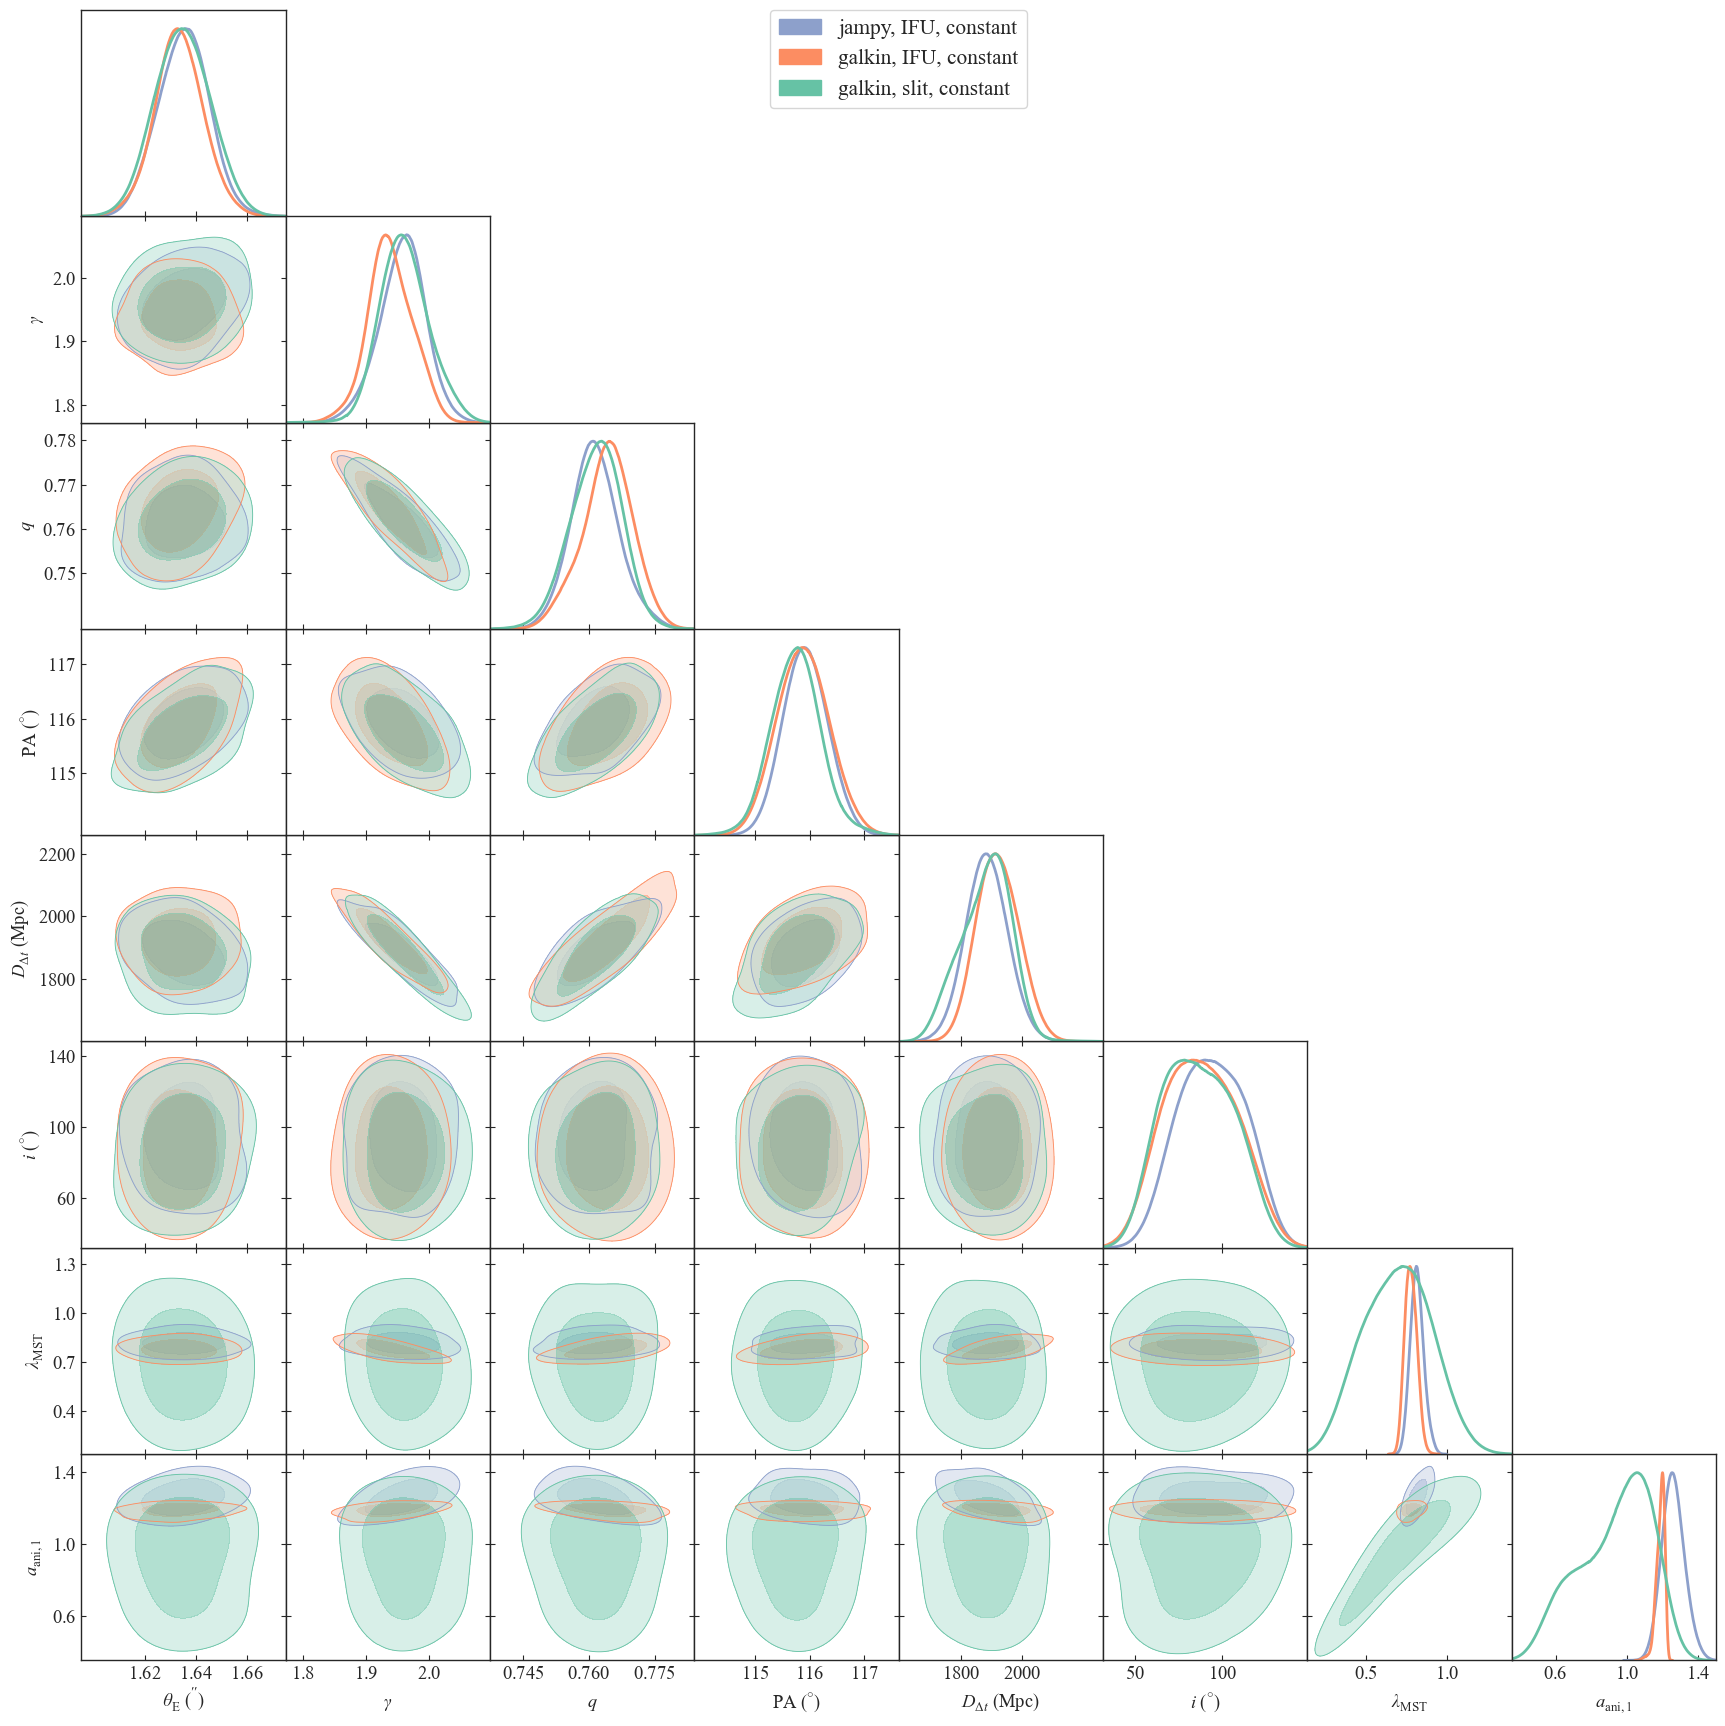

In [6]:
plot_dist(['jampy', 'galkin', 'galkin'], 
          ['ifu', 'ifu', 'single_slit'], 
          ['constant', 'constant', 'constant'], 
          [True, True, True], 
          ['powerlaw', 'powerlaw', 'powerlaw'], 
          burnin=-50, legend_labels=['jampy, IFU, constant', 'galkin, IFU, constant', 'galkin, slit, constant'])

Removed no burn in
Removed no burn in


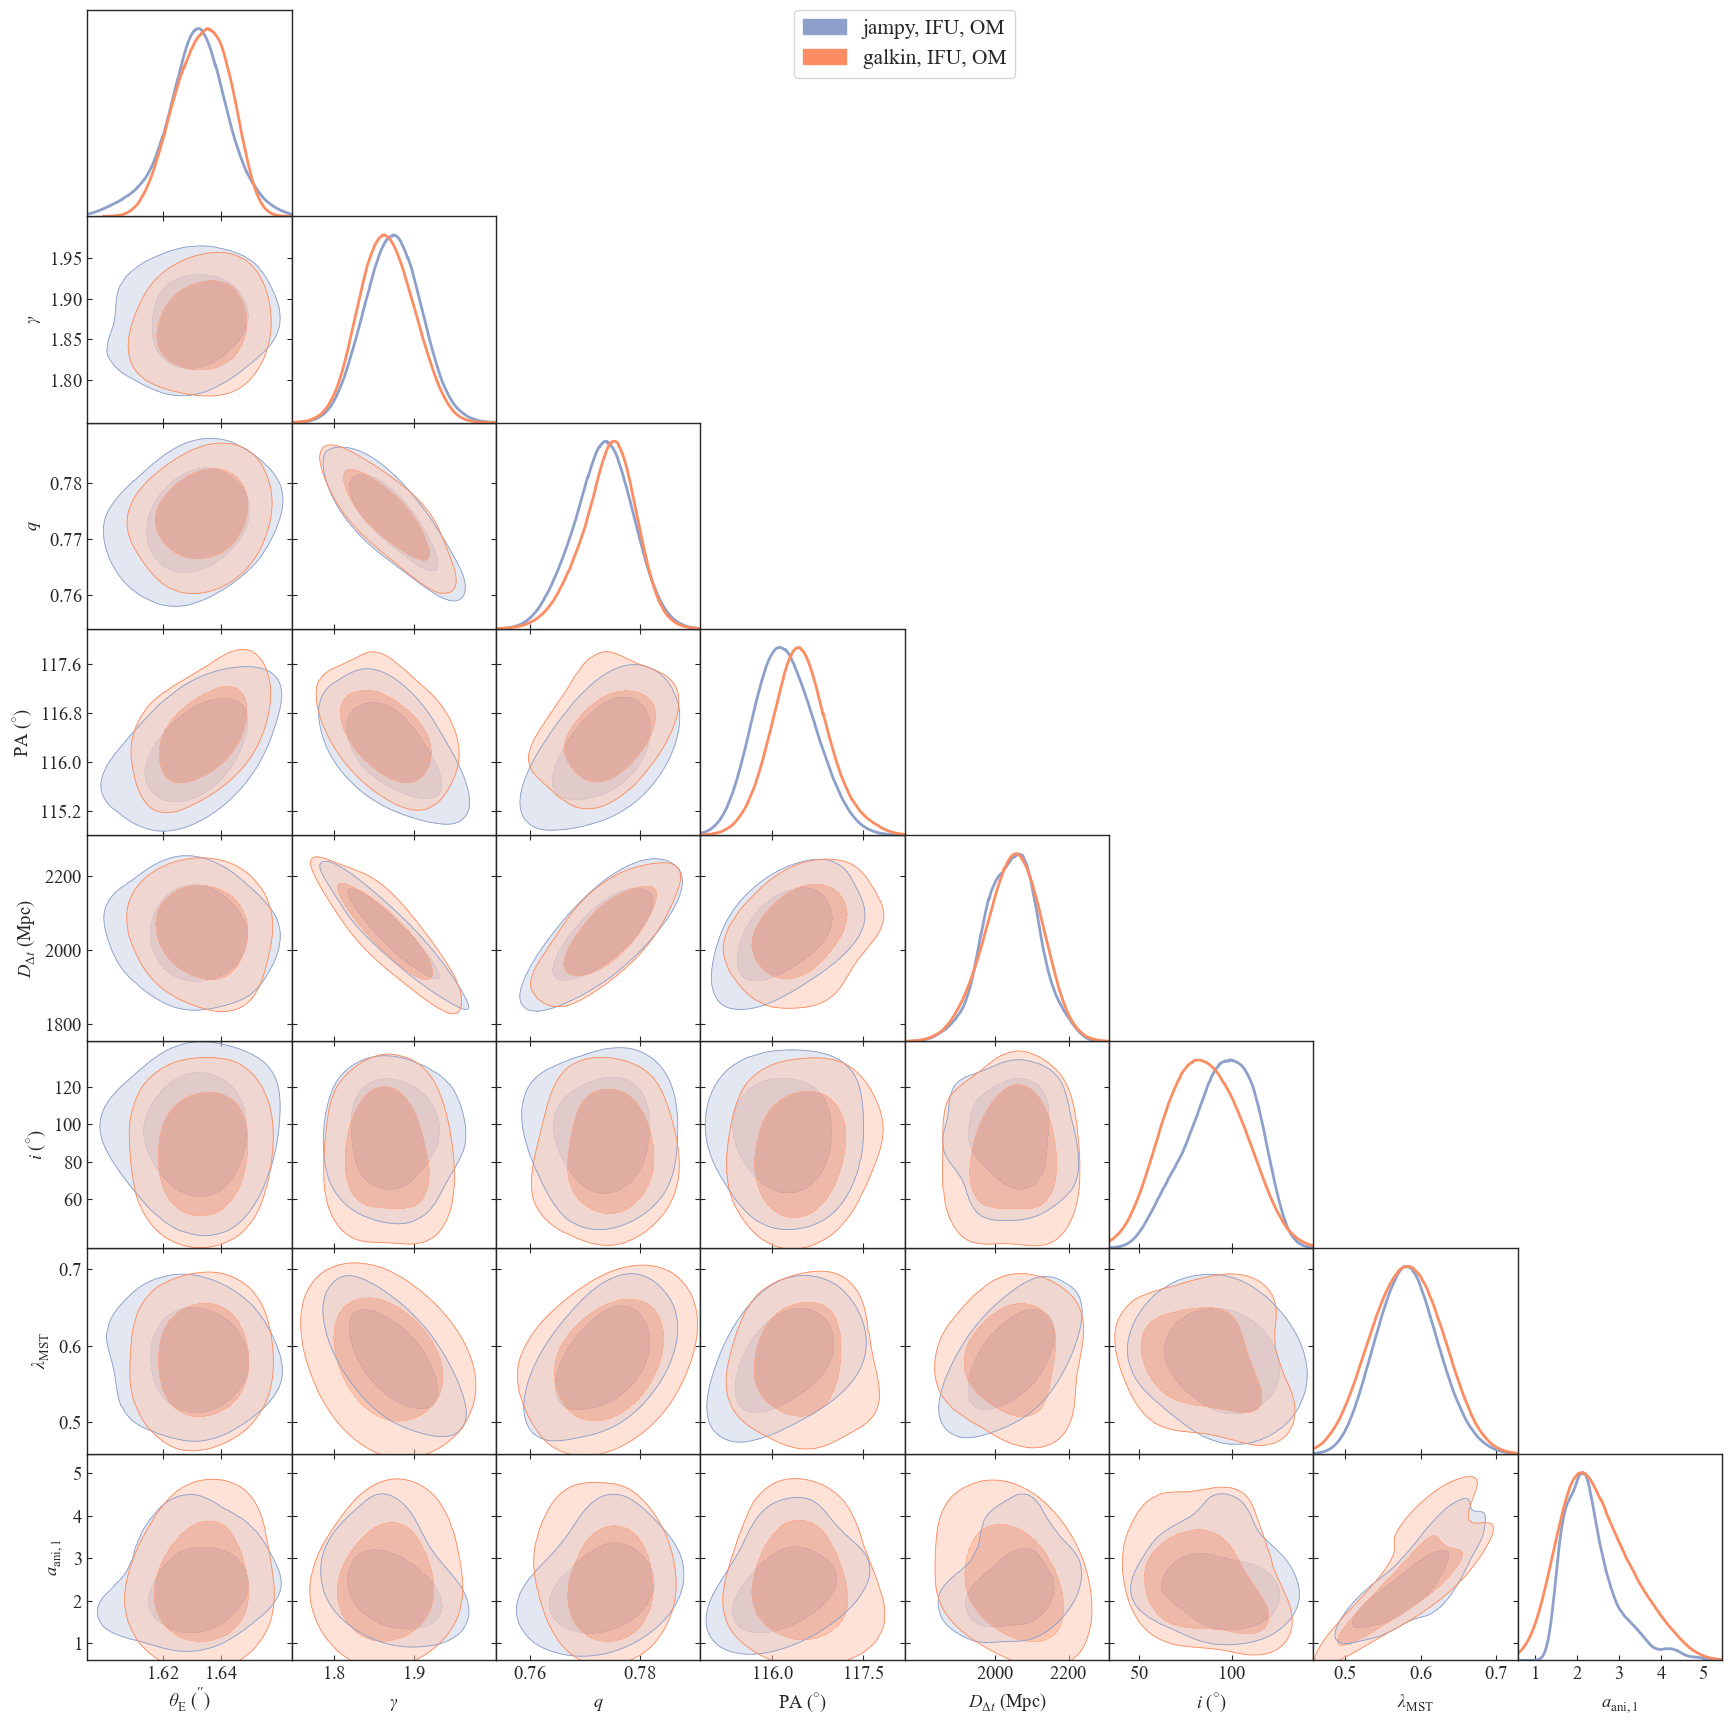

In [7]:
plot_dist(['jampy', 'galkin'], 
          ['ifu', 'ifu'], 
          ['Osipkov-Merritt', 'Osipkov-Merritt'], 
          [True, True], 
          ['powerlaw', 'powerlaw'], 
          burnin=-50, legend_labels=['jampy, IFU, OM', 'galkin, IFU, OM'])

Removed no burn in
Removed no burn in


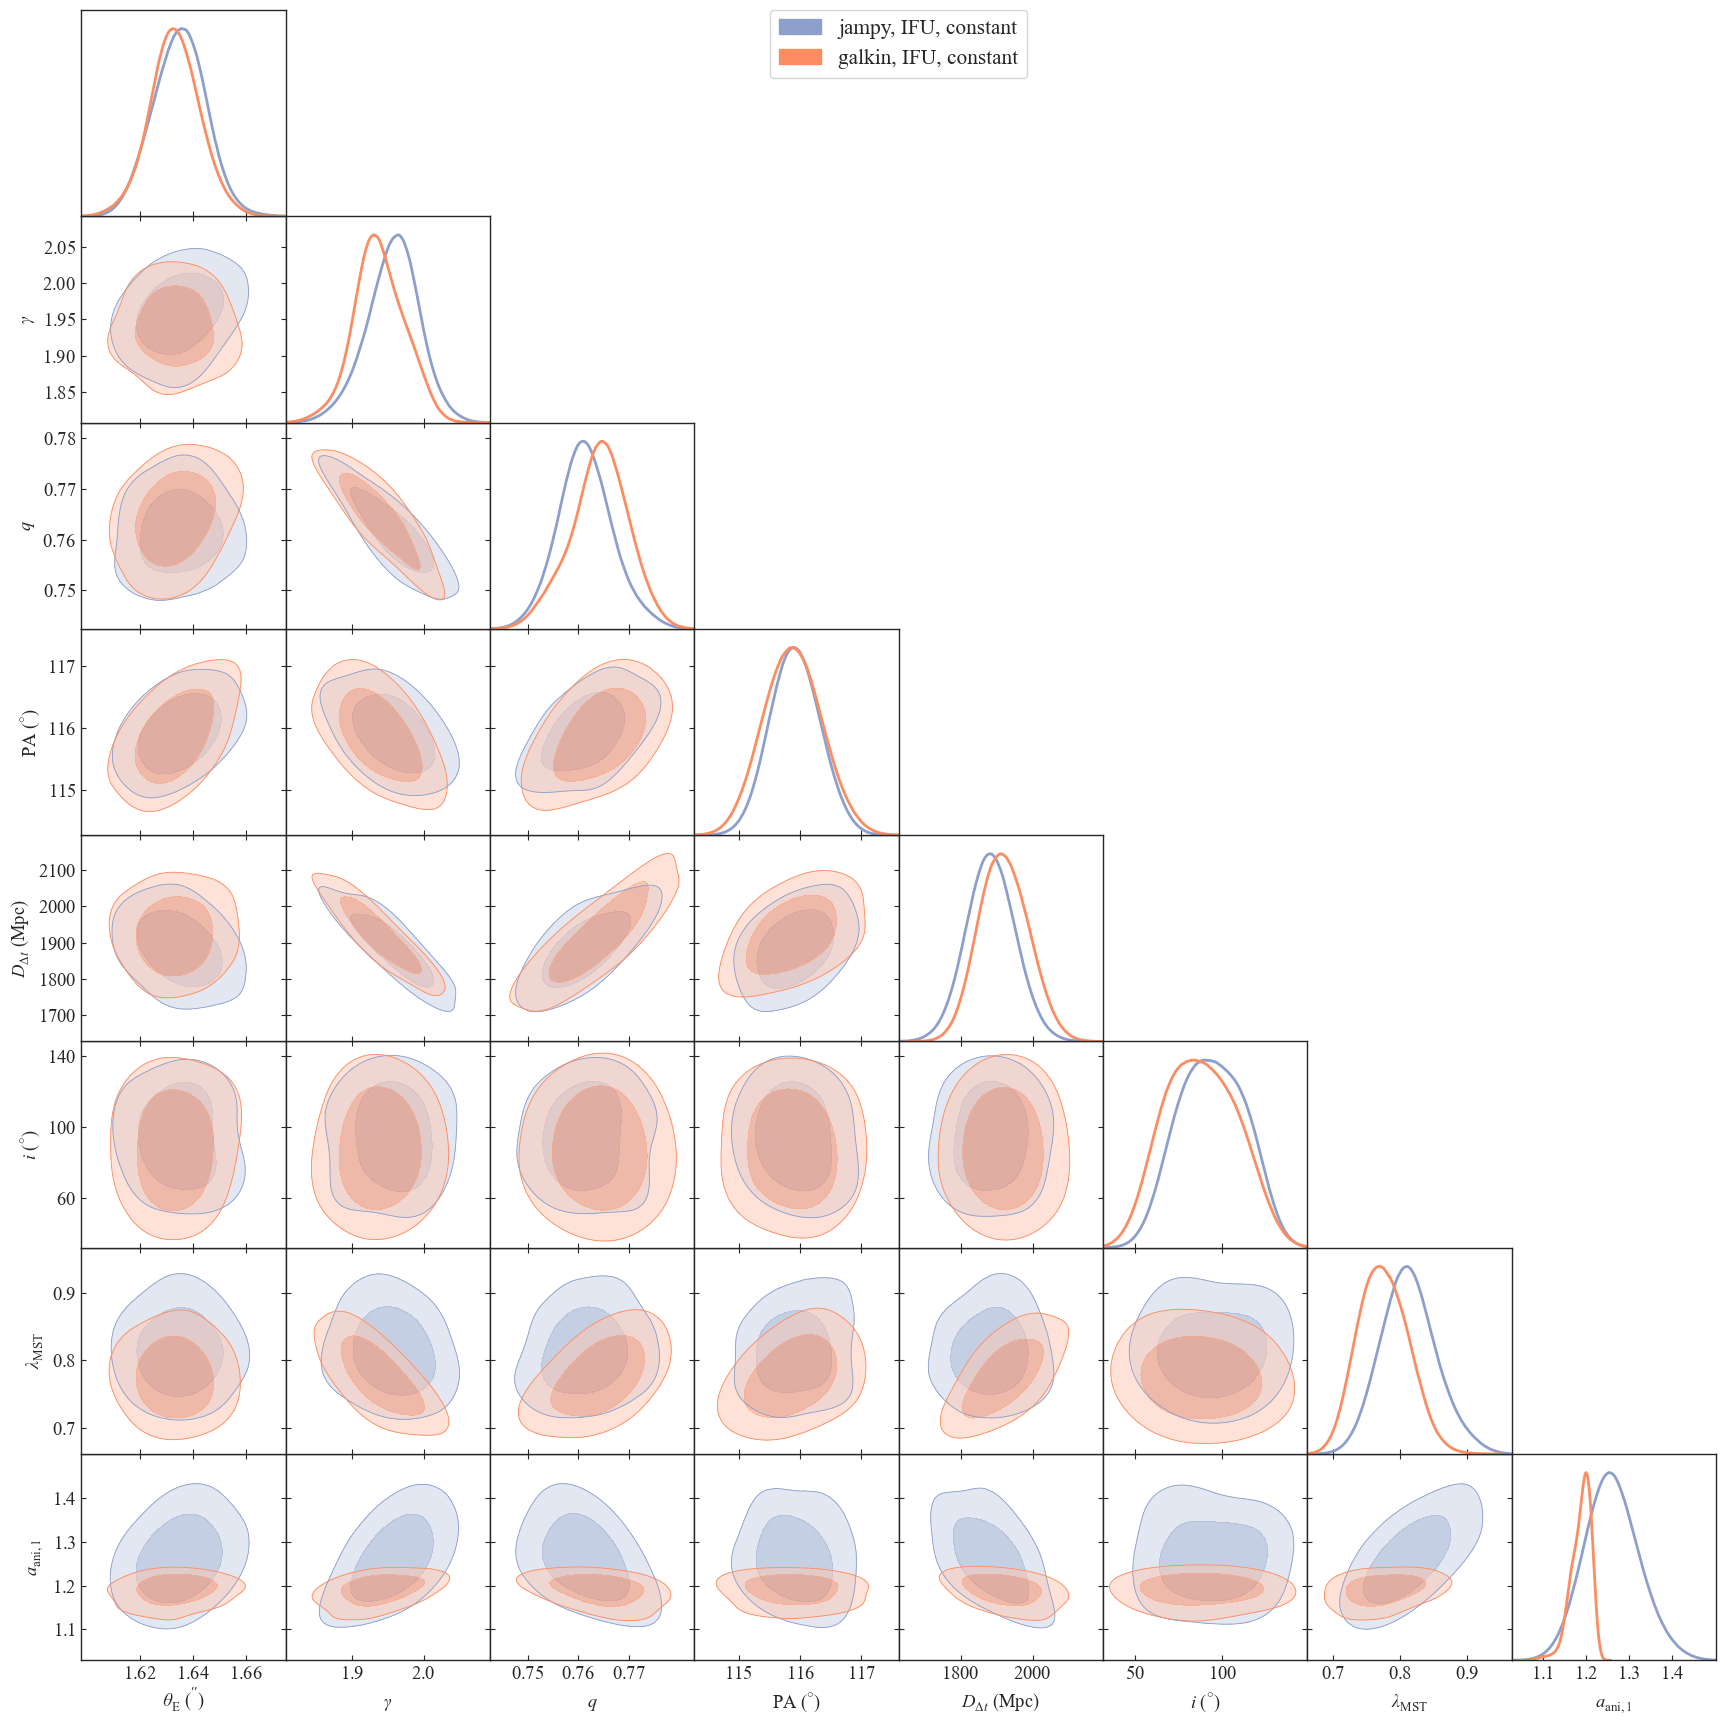

In [8]:
plot_dist(['jampy', 'galkin'], 
          ['ifu', 'ifu'], 
          ['constant', 'constant'], 
          [True, True], 
          ['powerlaw', 'powerlaw'], 
          burnin=-50, legend_labels=['jampy, IFU, constant', 'galkin, IFU, constant'])

Removed no burn in
Removed no burn in
Removed no burn in


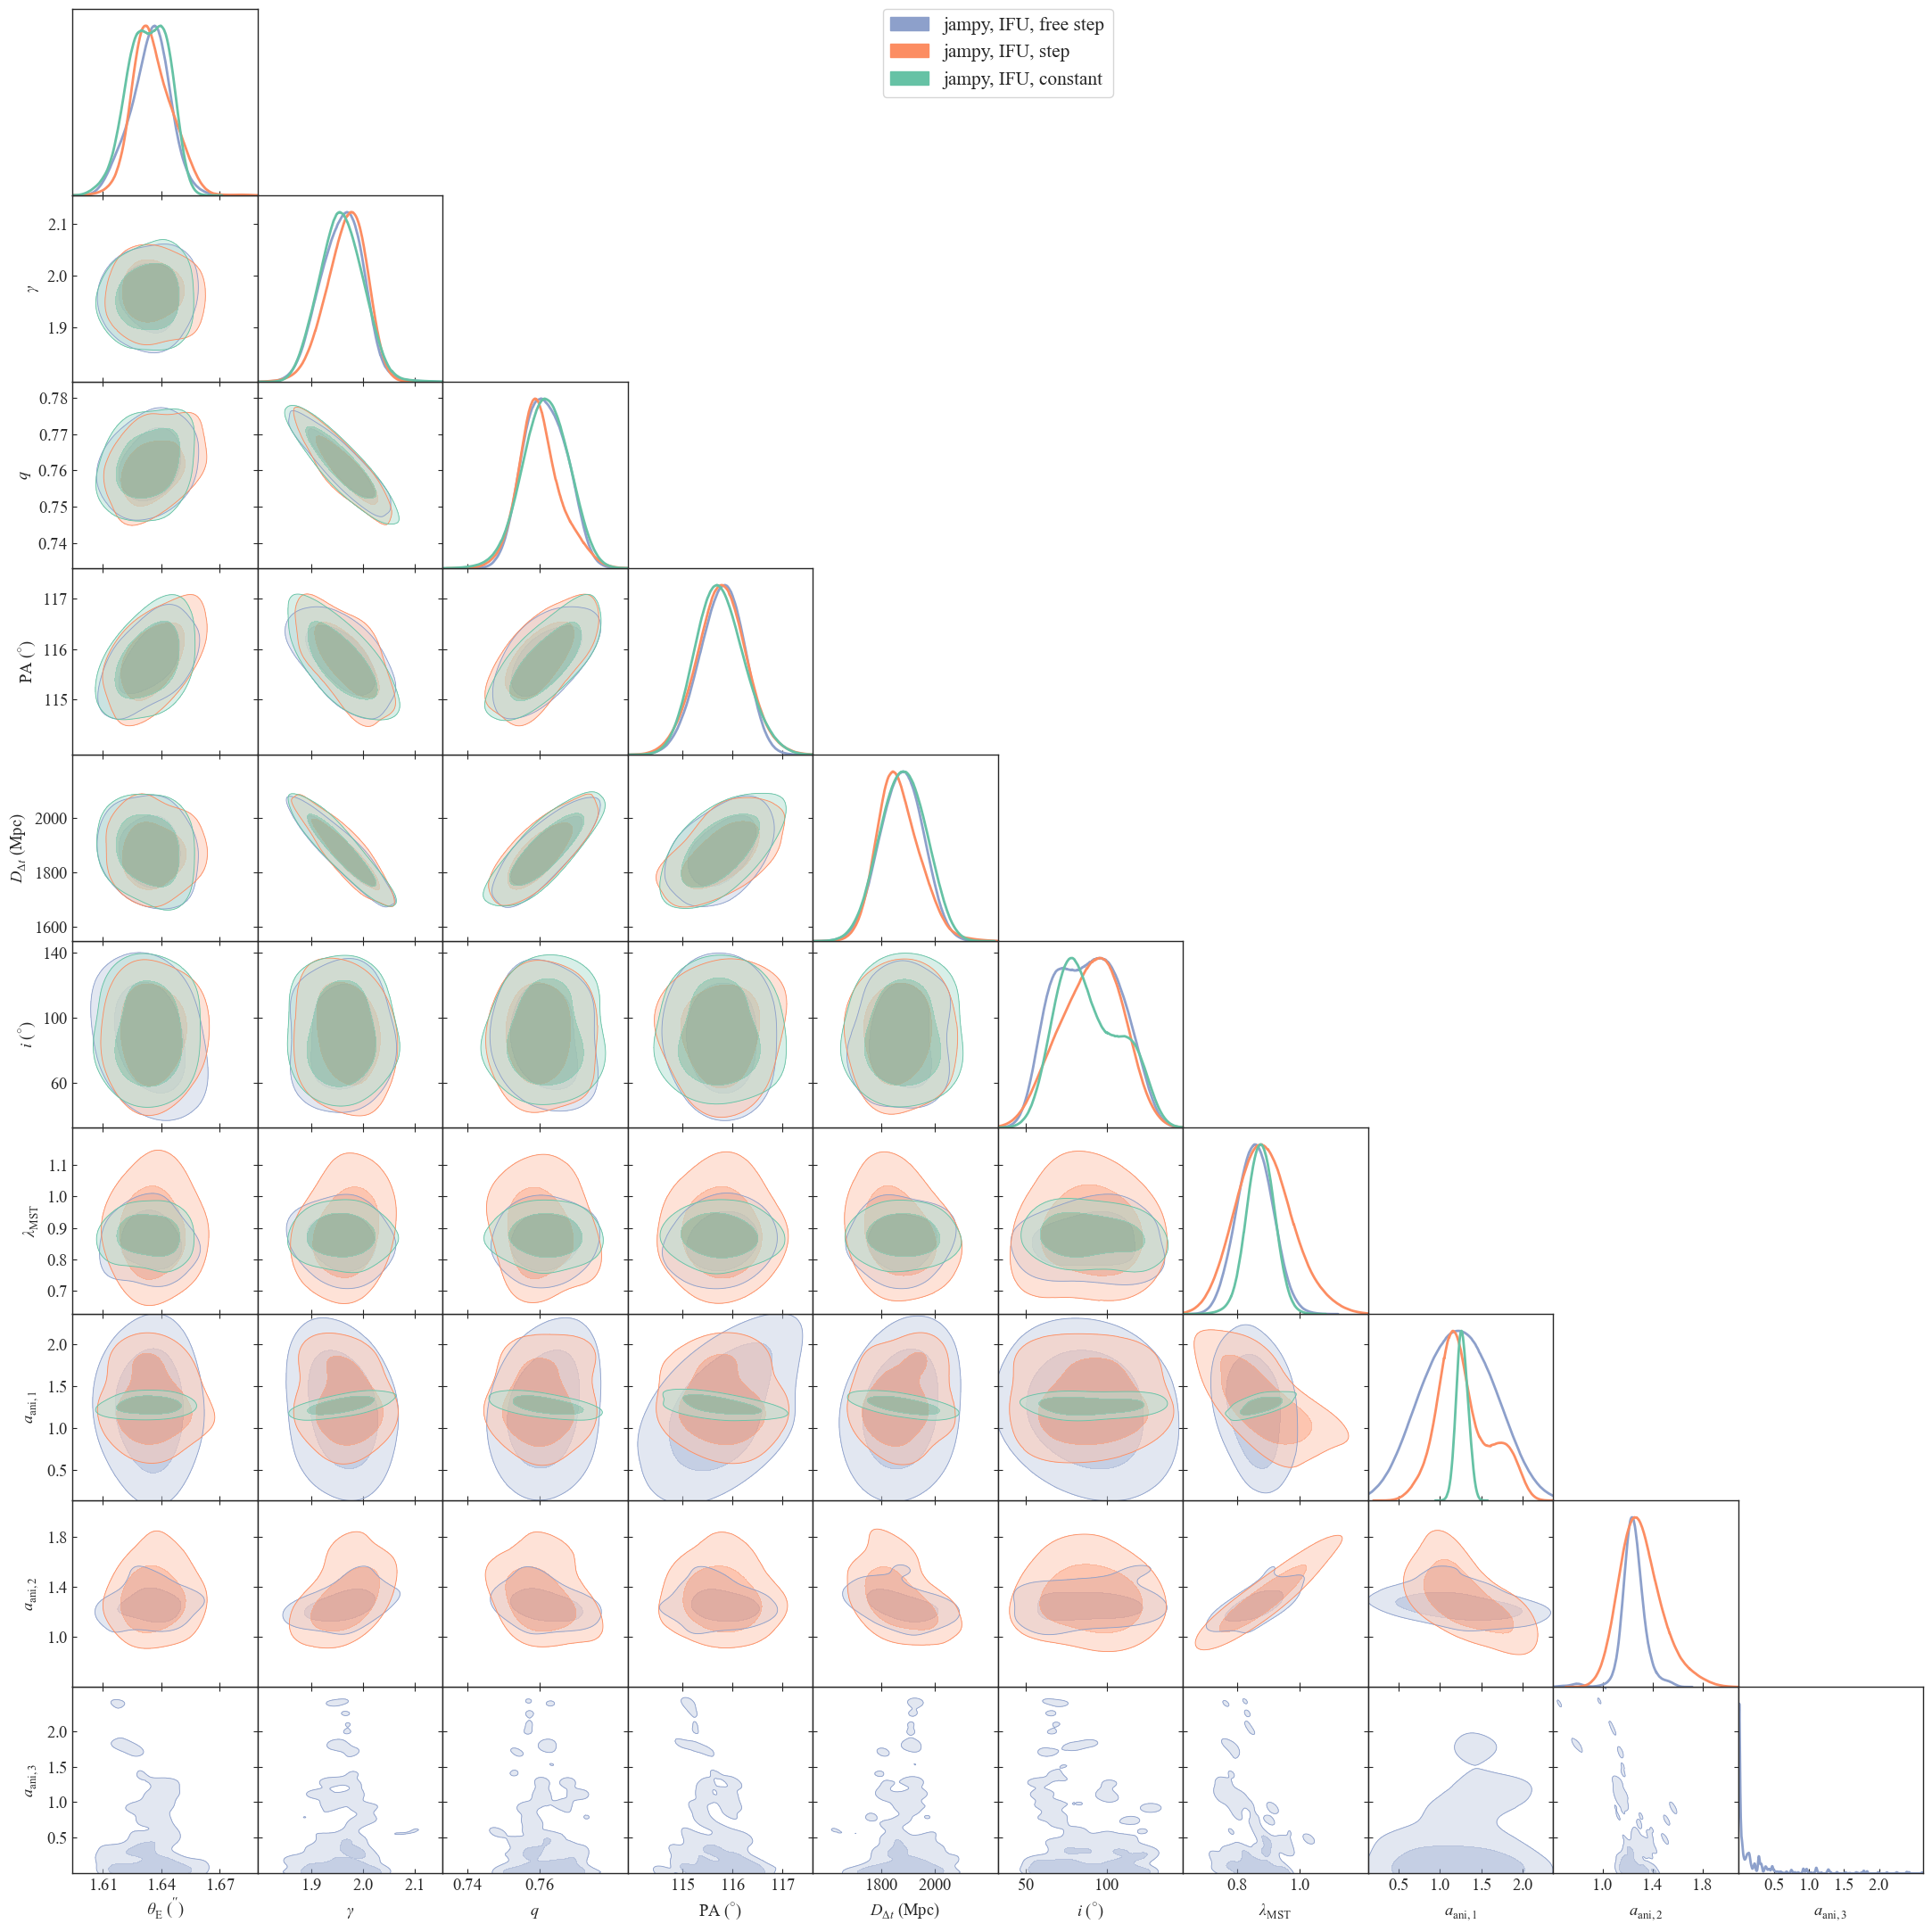

In [9]:
plot_dist(['jampy', 'jampy', 'jampy'], 
          ['ifu', 'ifu', 'ifu'], 
          ['free_step', 'step', 'constant'], 
          [False, False, False], 
          ['powerlaw', 'powerlaw', 'powerlaw'], 
          burnin=-50, legend_labels=['jampy, IFU, free step',  'jampy, IFU, step', 'jampy, IFU, constant'])

Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`
reduced chi^2: 1.70


/var/folders/ry/23z2z0bd7_d814t1jlq8ydlw0000gn/T/ipykernel_23138/471817866.py:289: RuntimeWarning: invalid value encountered in true_divide
  im = plt.matshow((data_v_rms - model_v_rms) / noise_v_rms,


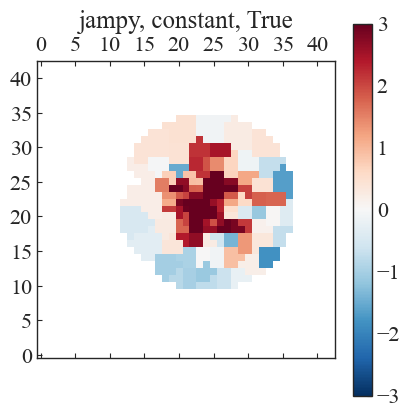

Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`
reduced chi^2: 1.63


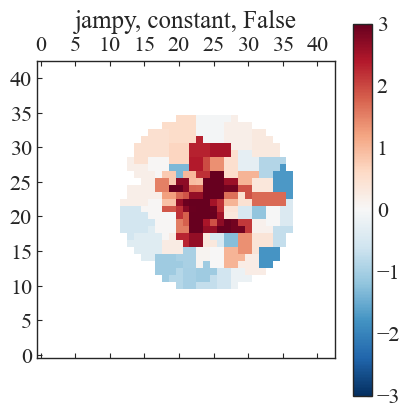

In [10]:
plot_residual('jampy', 'ifu', 'constant', True, 'powerlaw', burnin=-2);
#plot_residual('jampy', 'ifu', 'constant', False, 'powerlaw');
plot_residual('jampy', 'ifu', 'constant', False, 'powerlaw', burnin=-2);

Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`
reduced chi^2: 1.62


/var/folders/ry/23z2z0bd7_d814t1jlq8ydlw0000gn/T/ipykernel_23138/471817866.py:289: RuntimeWarning: invalid value encountered in true_divide
  im = plt.matshow((data_v_rms - model_v_rms) / noise_v_rms,


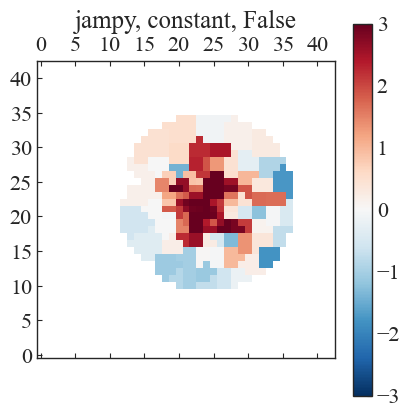

FileNotFoundError: ../dynamics_chains_old/kcwi_dynamics_chain_jampy_ifu_Osipkov-Merritt_False_composite.txt not found.

In [11]:
plot_residual('jampy', 'ifu', 'constant', False, 'powerlaw', burnin=-2);
#plot_residual('jampy', 'ifu', 'constant', False, 'powerlaw');
plot_residual('jampy', 'ifu', 'Osipkov-Merritt', False, 'composite', burnin=-2);

In [ ]:
get_most_likely_value('jampy', 'ifu', 'constant', False, 'powerlaw', burnin=-2)

In [1]:
print(get_bic('jampy', 'ifu', 'Osipkov-Merritt', True, 'powerlaw', burnin=-2))
print(get_bic('jampy', 'ifu', 'constant', False, 'powerlaw', burnin=-2))
print(get_bic('jampy', 'ifu', 'constant', True, 'powerlaw', burnin=-2))
print(get_bic('jampy', 'ifu', 'step', False, 'powerlaw', burnin=-2))
print(get_bic('jampy', 'ifu', 'free_step', False, 'powerlaw', burnin=-2))

NameError: name 'get_bic' is not defined

In [ ]:
print(get_bic('jampy', 'ifu', 'constant', False, 'powerlaw', burnin=-2))
print(get_bic('jampy', 'ifu', 'constant', False, 'composite', burnin=-2))
print(get_bic('jampy', 'ifu', 'Osipkov-Merritt', False, 'composite', burnin=-2))

In [ ]:
plot_dist(['jampy', 'jampy', 'jampy'], 
          ['ifu', 'ifu', 'ifu'], 
          ['constant', 'step', 'free_step'], 
          [False, False, False], 
          ['composite', 'composite', 'composite'], 
          burnin=-50, legend_labels=['jampy, IFU, constant', 'jampy, IFU, step', 'jampy, IFU, free step'])